| **Name**         | Tufan Kundu               |
|------------------|---------------------------|
| **Reg No.**      | 24MDT0184                 |
| **Course Name**  | Financial Analytics Lab   |
| **Course Code**  | PMDS610P                  |
| **Assessment**   | Lab Digital Assessment 3  |


# Problem Statement
You are given historical daily closing prices of the NIFTY 50 index from the National Stock Exchange of India (NSE). Your task is to analyze and  forecast stock prices using an Regression model with time series error.

### Importing the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings 
warnings.filterwarnings('ignore')


In [3]:
# -----------------------------------------------
# 2.1 Data Preprocessing
# -----------------------------------------------
nifty = yf.download("^NSEI", start="2019-01-01", end="2024-01-01")
nifty = nifty[['Close']]
nifty.index = pd.to_datetime(nifty.index)
print("Missing values before handling:", nifty['Close'].isna().sum())
nifty.dropna(inplace=True)
print("Missing values after handling:", nifty['Close'].isna().sum())



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Missing values before handling: Ticker
^NSEI    0
dtype: int64
Missing values after handling: Ticker
^NSEI    0
dtype: int64


In [4]:
# -----------------------------------------------
# 2.2 Stationarity Check
# -----------------------------------------------
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    return result[1]

p_val = adf_test(nifty['Close'])

if p_val > 0.05:
    print("Series is non-stationary. Applying first-order differencing...")
    nifty_diff = nifty['Close'].diff().dropna()
    adf_test(nifty_diff)
else:
    print("Series is stationary.")
    nifty_diff = nifty['Close']


ADF Statistic: -0.1888
p-value: 0.9398
Series is non-stationary. Applying first-order differencing...
ADF Statistic: -12.2918
p-value: 0.0000


In [5]:
# -----------------------------------------------
# 2.3 Model Selection & Training
# -----------------------------------------------
nifty['Time'] = np.arange(len(nifty))
split = int(len(nifty) * 0.8)
train = nifty.iloc[:split]
test = nifty.iloc[split:]

X_train = train[['Time']]
y_train = train['Close']
X_test = test[['Time']]
y_test = test['Close']

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
residuals = y_train - y_pred_train


In [6]:
# Check stationarity of residuals
adf_residuals = adfuller(residuals)
print(f"\nADF Test on Residuals:")
print(f"ADF Statistic: {adf_residuals[0]}")
print(f"p-value: {adf_residuals[1]}")

# Fit ARMA model to residuals (ARIMA with d=0)
arma_model = ARIMA(residuals, order=(2, 0, 2)).fit()
print("\nARMA Model Summary:")
print(arma_model.summary())




ADF Test on Residuals:
ADF Statistic: -2.1465498132914145
p-value: 0.22621307051827794

ARMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  ^NSEI   No. Observations:                  985
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6406.601
Date:                Sat, 05 Apr 2025   AIC                          12825.201
Time:                        15:43:41   BIC                          12854.557
Sample:                             0   HQIC                         12836.367
                                - 985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011    688.632   1.66e-06      1.000   -1349.693    1349.696
ar.L1          0.1253 

In [7]:
# -----------------------------------------------
# 2.4 Model Evaluation
# -----------------------------------------------
y_pred_reg = lr.predict(X_test).ravel()
residuals_forecast = arma_model.forecast(steps=len(X_test))
y_pred_final = y_pred_reg + residuals_forecast.values

mse = mean_squared_error(y_test, y_pred_final)
mape = mean_absolute_percentage_error(y_test, y_pred_final)

print(f"\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")



Model Evaluation:
Mean Squared Error (MSE): 590709.10
Mean Absolute Percentage Error (MAPE): 3.45%


In [8]:
# -----------------------------------------------
# 2.5 Forecasting Future Prices
# -----------------------------------------------
future_time = np.arange(len(nifty), len(nifty) + 30).reshape(-1, 1)
future_reg = lr.predict(future_time).ravel()
future_resid = arma_model.forecast(steps=30)
forecast = future_reg + future_resid.values

forecast_dates = pd.date_range(start=nifty.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# -----------------------------------------------
# Display Forecasted Future Prices
# -----------------------------------------------
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Close_Price': forecast
})
forecast_df.set_index('Date', inplace=True)

print("\nForecasted NIFTY 50 Closing Prices for the Next 30 Business Days:")
print(forecast_df.round(2))



Forecasted NIFTY 50 Closing Prices for the Next 30 Business Days:
            Forecasted_Close_Price
Date                              
2024-01-01                20367.45
2024-01-02                20373.51
2024-01-03                20388.89
2024-01-04                20396.16
2024-01-05                20410.43
2024-01-08                20418.60
2024-01-09                20432.04
2024-01-10                20440.88
2024-01-11                20453.69
2024-01-12                20463.03
2024-01-15                20475.35
2024-01-16                20485.06
2024-01-17                20497.00
2024-01-18                20506.98
2024-01-19                20518.64
2024-01-22                20528.82
2024-01-23                20540.26
2024-01-24                20550.58
2024-01-25                20561.84
2024-01-26                20572.26
2024-01-29                20583.39
2024-01-30                20593.88
2024-01-31                20604.90
2024-02-01                20615.44
2024-02-02             

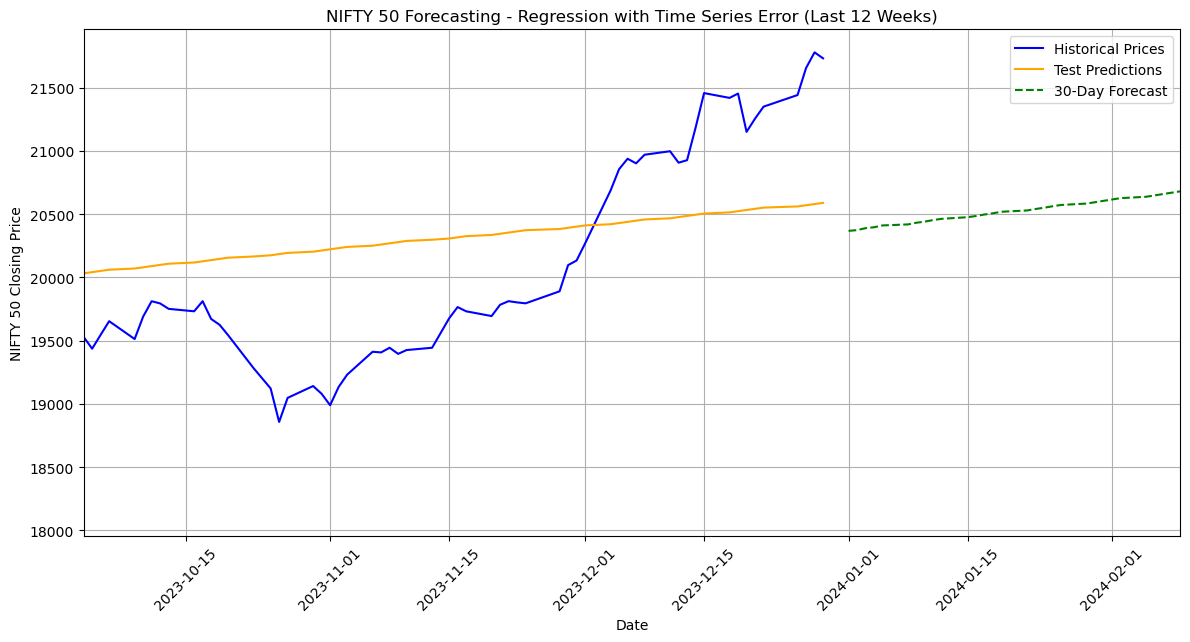

In [9]:

# -----------------------------------------------
# Visualization (Focus on last few weeks)
# -----------------------------------------------
last_n_days = 60
start_date = nifty.index[-last_n_days]

plt.figure(figsize=(12, 6))
plt.plot(nifty.index[-last_n_days:], nifty['Close'][-last_n_days:], label='Historical Prices', color='blue')
plt.plot(test.index[-len(y_pred_final):], y_pred_final, label='Test Predictions', color='orange')
plt.plot(forecast_dates, forecast, label='30-Day Forecast', color='green', linestyle='--')
plt.xlabel("Date")
plt.ylabel("NIFTY 50 Closing Price")
plt.title("NIFTY 50 Forecasting - Regression with Time Series Error (Last 12 Weeks)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.xlim(start_date, forecast_dates[-1])
plt.show()